# Case Study Analysis Notebook

The purpose of this code is to create a set of graphs based on one shapefile.  It is a combination of many of the other notebooks consolidated into this one.

To run this code, you need the following files in the appropriate folders
 - Data/Input
   > Master_ADWR_database_noduplicates.shp
   > Master_ADWR_database_water.shp
   > Yearly_DroughtIndices_updated12032023.csv
 - Data/Output_files
   > Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv
 - Data/Shapefiles
   > Any shapefiles of your choosing

In [55]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
#import earthpy as et
import scipy.stats as sp
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/'


In [56]:
# %% Creating colors
c_1 = '#8d5a99' # Reservation
c_2 = "#d7191c" # Regulated with CAP (Water Category Color)
c_3 = '#e77a47' # Regulated without CAP (Water Category Color)
c_4 = '#2cbe21' # Lower CO River - SW (Water Category Color)
c_5 = '#2f8c73' # Upper CO River - Mixed (Water Category Color)
c_6 = '#6db7e8' # SE - GW
c_7 = '#165782' # NW - GW (Water Category color)
c_8 = '#229ce8' # SC - GW
c_9 = '#1f78b4' # NE - GW
c_10 = '#41bf9e' # N - Mixed
c_11 = '#7adec4' # C - Mixed
drought_color = '#ffa6b8'
wet_color = '#b8d3f2'

reg_colors = [c_2,c_7]
georeg_colors = [c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11]
SW_colors = [c_2,c_3,c_4,c_5,c_7]

bar_watercatc = [c_2,c_3,c_4,c_5,c_7]


# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Matching new map

grace_color = '#A92B2A'
az_wells_color = '#1D4E77'

cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'

In [57]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [58]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


Read in the main databases.  You only have to do this once.

Master Database might take a while (~5-7 minutes).

In [59]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../../Data/Output/Local\Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 254720 entries, 0 to 254719
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    254720 non-null  object  
 1   OBJECTID_g  45631 non-null   float64 
 2   SITE_ID     45631 non-null   object  
 3   LOCAL_ID    45631 non-null   object  
 4   REGISTRY_I  233584 non-null  object  
 5   WELL_TYPE   45631 non-null   object  
 6   DD_LAT      45631 non-null   float64 
 7   DD_LONG     45631 non-null   float64 
 8   LAT_NAD27   45631 non-null   object  
 9   LONG_NAD27  45631 non-null   object  
 10  WELL_ALT    45631 non-null   float64 
 11  WATER_USE_  45573 non-null   object  
 12  WELL_DEPTH  214498 non-null  float64 
 13  CASE_DIAM   33772 non-null   float64 
 14  WL_COUNT    45631 non-null   float64 
 15  WL_DTW      34716 non-null   float64 
 16  WL_ELEV     34716 non-null   float64 
 1

This one takes about 3-4 minutes to run

In [60]:
# Read in the database of number water wells
filename_mdb_w = 'Master_ADWR_database_water.shp'
filepath = os.path.join(outputpath, filename_mdb_w)
print(filepath)

masterdb_water = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb_water.info())

../../Data/Output/Local\Master_ADWR_database_water.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 142717 entries, 0 to 142716
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    142717 non-null  object  
 1   OBJECTID_g  45631 non-null   float64 
 2   SITE_ID     45631 non-null   object  
 3   LOCAL_ID    45631 non-null   object  
 4   REGISTRY_I  121581 non-null  object  
 5   WELL_TYPE   45631 non-null   object  
 6   DD_LAT      45631 non-null   float64 
 7   DD_LONG     45631 non-null   float64 
 8   LAT_NAD27   45631 non-null   object  
 9   LONG_NAD27  45631 non-null   object  
 10  WELL_ALT    45631 non-null   float64 
 11  WATER_USE_  45573 non-null   object  
 12  WELL_DEPTH  130667 non-null  float64 
 13  CASE_DIAM   33772 non-null   float64 
 14  WL_COUNT    45631 non-null   float64 
 15  WL_DTW      34716 non-null   float64 
 16  WL_ELEV     34716 non-null   float64 
 17  SOUR

In [61]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

../../Data/Output/Local\Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv


,Combo_ID,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,...,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
0,60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,497.70,495.30,NaN,489.85,NaN,487.85,485.10,483.50,483.90,NaN
1,85358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,262.43,254.88,251.65,251.53,NaN,NaN,NaN,NaN,NaN
2,85761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.70,45.50,45.30,46.30,45.00,46.20,43.50,41.40,45.80,NaN
3,85799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.30,59.80,57.80,59.50,60.10,59.40,60.80,62.10,62.10,NaN
4,85863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,114.74,115.50,116.26,117.10,119.34,118.49,119.77,120.65,119.83,120.71


### From here down is where you can rerun the code to generate graphs

<Axes: >

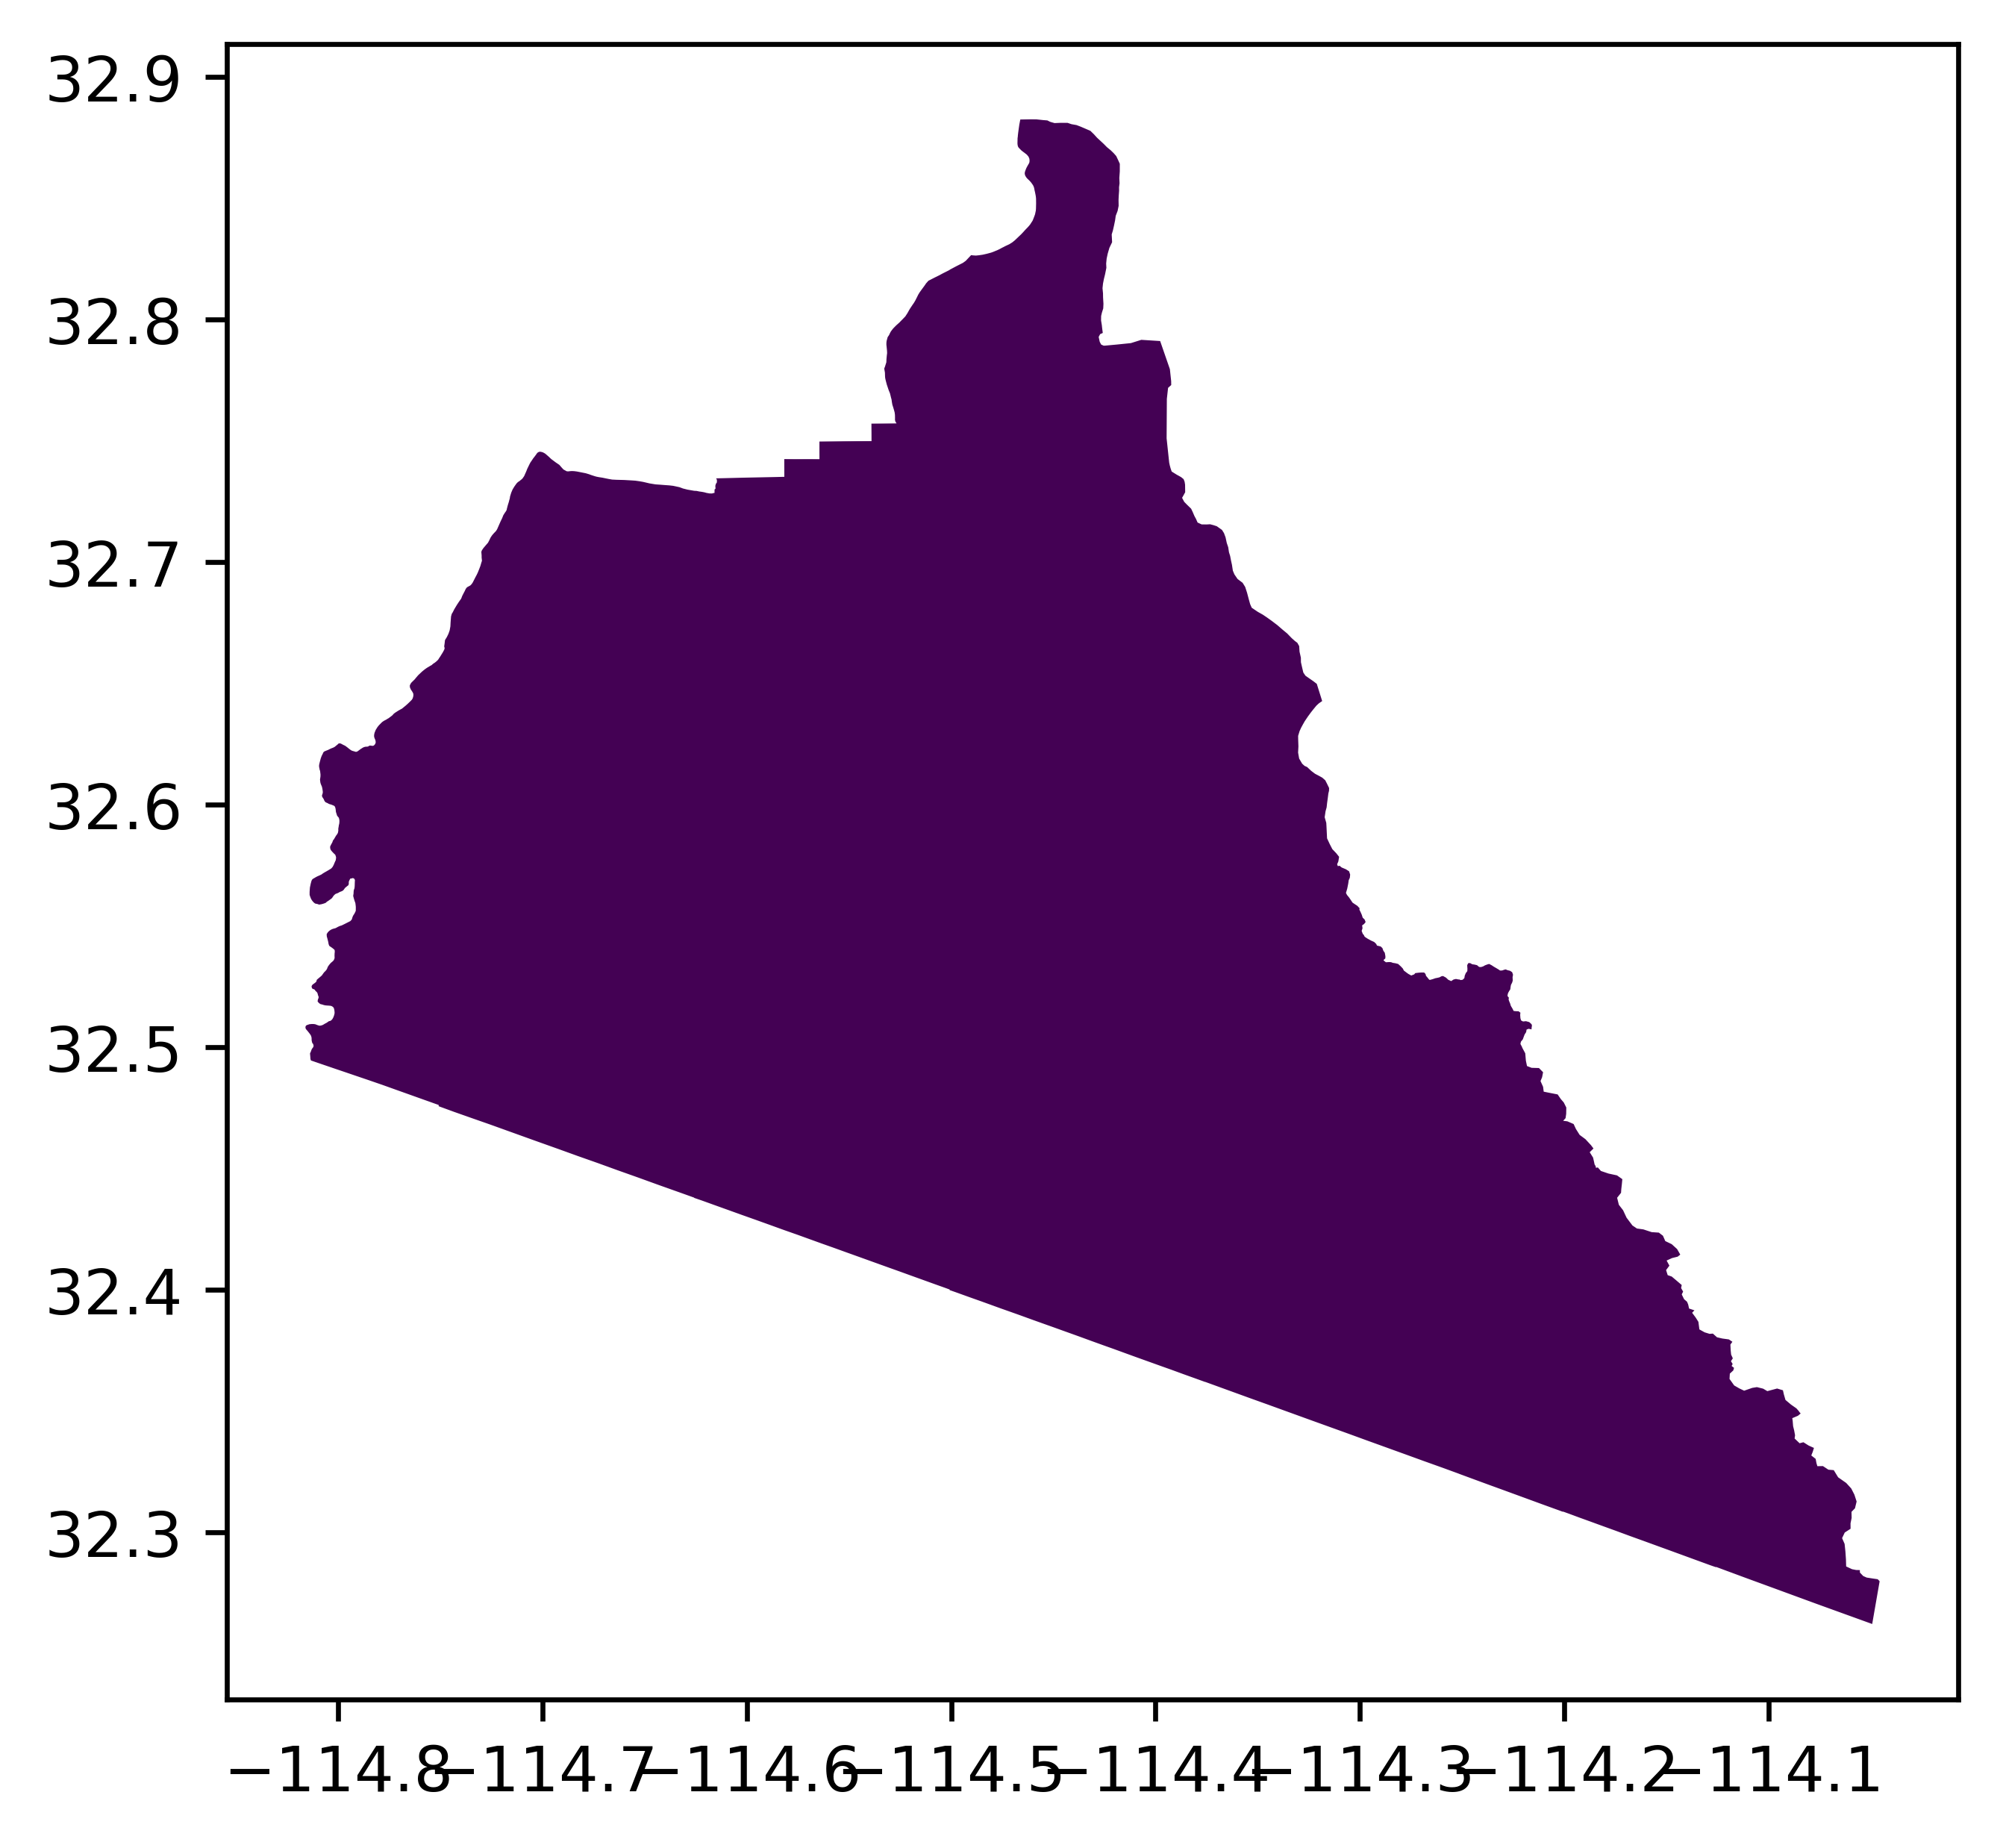

In [62]:
# Read in the shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = 'Yuma.shp'
filepath = os.path.join(shapepath, filename_shapeile)
shapefile = gp.read_file(filepath)
shapefile.plot(cmap='viridis')


Take a look at the columns and variables

In [63]:
shapefile

,Name,FID,AMA_CODE,SUBBASIN_N,NAME_ABBR,SUBBASIN_1,SHAPEAREA,layer,path,geometry
0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-114.46620 32.88249 0.00000, -114...."


In [64]:
# Define some things about your file

StudyArea = "Yuma"
# Naming_col = "Name"
Naming_col = "SUBBASIN_N"
water_designation = swdom 

Merging the databases takes a little time - Approximately 3 minutes

In [65]:
# Merge the shapefile with the master database

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
masterdb_water = masterdb_water.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile, how="inner", op='intersects')

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")

# %% For the water wells water wells
static_geo2 = gp.sjoin(masterdb_water, shapefile, how="inner", op='intersects')
static_geo2.head()
print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and Yuma.shp join complete.


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and Yuma.shp join complete.


Check to make sure the merged dataframe looks good

In [66]:
static_geo

,Combo_ID,OBJECTID_g,SITE_ID,LOCAL_ID,REGISTRY_I,WELL_TYPE,DD_LAT,DD_LONG,LAT_NAD27,LONG_NAD27,...,index_right,Name,FID,AMA_CODE,SUBBASIN_N_right,NAME_ABBR,SUBBASIN_1,SHAPEAREA,layer,path
43,084808,NaN,NaN,NaN,084808,NaN,NaN,NaN,NaN,NaN,...,0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...
47,084812,NaN,NaN,NaN,084812,NaN,NaN,NaN,NaN,NaN,...,0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...
85,084965,NaN,NaN,NaN,084965,NaN,NaN,NaN,NaN,NaN,...,0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...
175,085071,NaN,NaN,NaN,085071,NaN,NaN,NaN,NaN,NaN,...,0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...
176,085072,NaN,NaN,NaN,085072,NaN,NaN,NaN,NaN,NaN,...,0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253933,930379,NaN,NaN,NaN,930379,NaN,NaN,NaN,NaN,NaN,...,0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...
254301,930764,NaN,NaN,NaN,930764,NaN,NaN,NaN,NaN,NaN,...,0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...
254405,930874,NaN,NaN,NaN,930874,NaN,NaN,NaN,NaN,NaN,...,0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...
254494,930966,NaN,NaN,NaN,930966,NaN,NaN,NaN,NaN,NaN,...,0,Yuma,NaN,0,YUMA,YUM,YUMA,2050496297.41,Yuma,/Users/danielletadych/Documents/PhD_Materials/...


In [67]:
# Pull out the columns you need
# Use this or subbasins:
reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]

# Use this or cities:
# reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_']]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

C:\Users\det19\AppData\Local\Temp\ipykernel_15116\4230821639.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [68]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Columns: 164 entries, Combo_ID to WELL_TYPE_
dtypes: float64(161), int64(1), object(2)
memory usage: 10.4+ KB


In [69]:
# Grouping the appropriate column
combo_copy = combo.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'],axis=1)
cat_wl = combo_copy.groupby([Naming_col+"_right"]).mean()
# cat_wl = combo_copy.groupby([Naming_col]).mean()

In [70]:
# Clean up the dataframe for graphing
cat_wl2 = cat_wl.copy()
i = cat_wl2
# del i['WELL_DEPTH']
f = i.transpose()
f.reset_index(inplace=True)
f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)
f.info()
cat_wl2 = f
cat_wl2

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 1853 to 2024
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YUMA    81 non-null     float64
dtypes: float64(1)
memory usage: 1.9 KB


SUBBASIN_N_right,YUMA
index,
1853,NaN
1856,NaN
1857,NaN
1860,NaN
1864,NaN
...,...
2020,62.19
2021,68.67
2022,70.00


### Analysis and Graphing

In [71]:
# Read in the drought indices

#  Input the date you downloaded the drought files
date_downloaded = "06102024"

drought_indices = pd.read_csv(f'{inputpath}/Yearly_DroughtIndices_updated{date_downloaded}.csv')
drought_indices = drought_indices.set_index('In_year')
print("Drought data loaded and formatted.")
# drought_indices

Drought data loaded and formatted.


In [83]:
Min_year_of_Study = 2000
Max_year_of_Study = 2022

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=Max_year_of_Study)]
drought_indices = drought_indices[(drought_indices.index>=Min_year_of_Study)&(drought_indices.index<=Max_year_of_Study)]
# del wlanalysis_period['Res'] # Only run this if doing regulation shapefile
wlanalysis_period.head()

SUBBASIN_N_right,YUMA
index,
2000,57.05
2001,76.49
2002,48.99
2003,50.26
2004,51.22


In [73]:
wlanalysis_period

SUBBASIN_N_right,YUMA
index,
2000,57.05
2001,76.49
2002,48.99
2003,50.26
2004,51.22
2005,52.12
2006,53.48
2007,60.73
2008,52.40


This is helpful if you're missing values and it won't calculate statistics

In [74]:
df_interpolated = wlanalysis_period.interpolate(method='linear', axis=0)
df_interpolated

SUBBASIN_N_right,YUMA
index,
2000,57.05
2001,76.49
2002,48.99
2003,50.26
2004,51.22
2005,52.12
2006,53.48
2007,60.73
2008,52.40


            Yuma
slope       0.53
int     -1006.77
rsq         0.28
p_val       0.01
std_err     0.18
mean       59.61
var        43.60
sum      1371.09


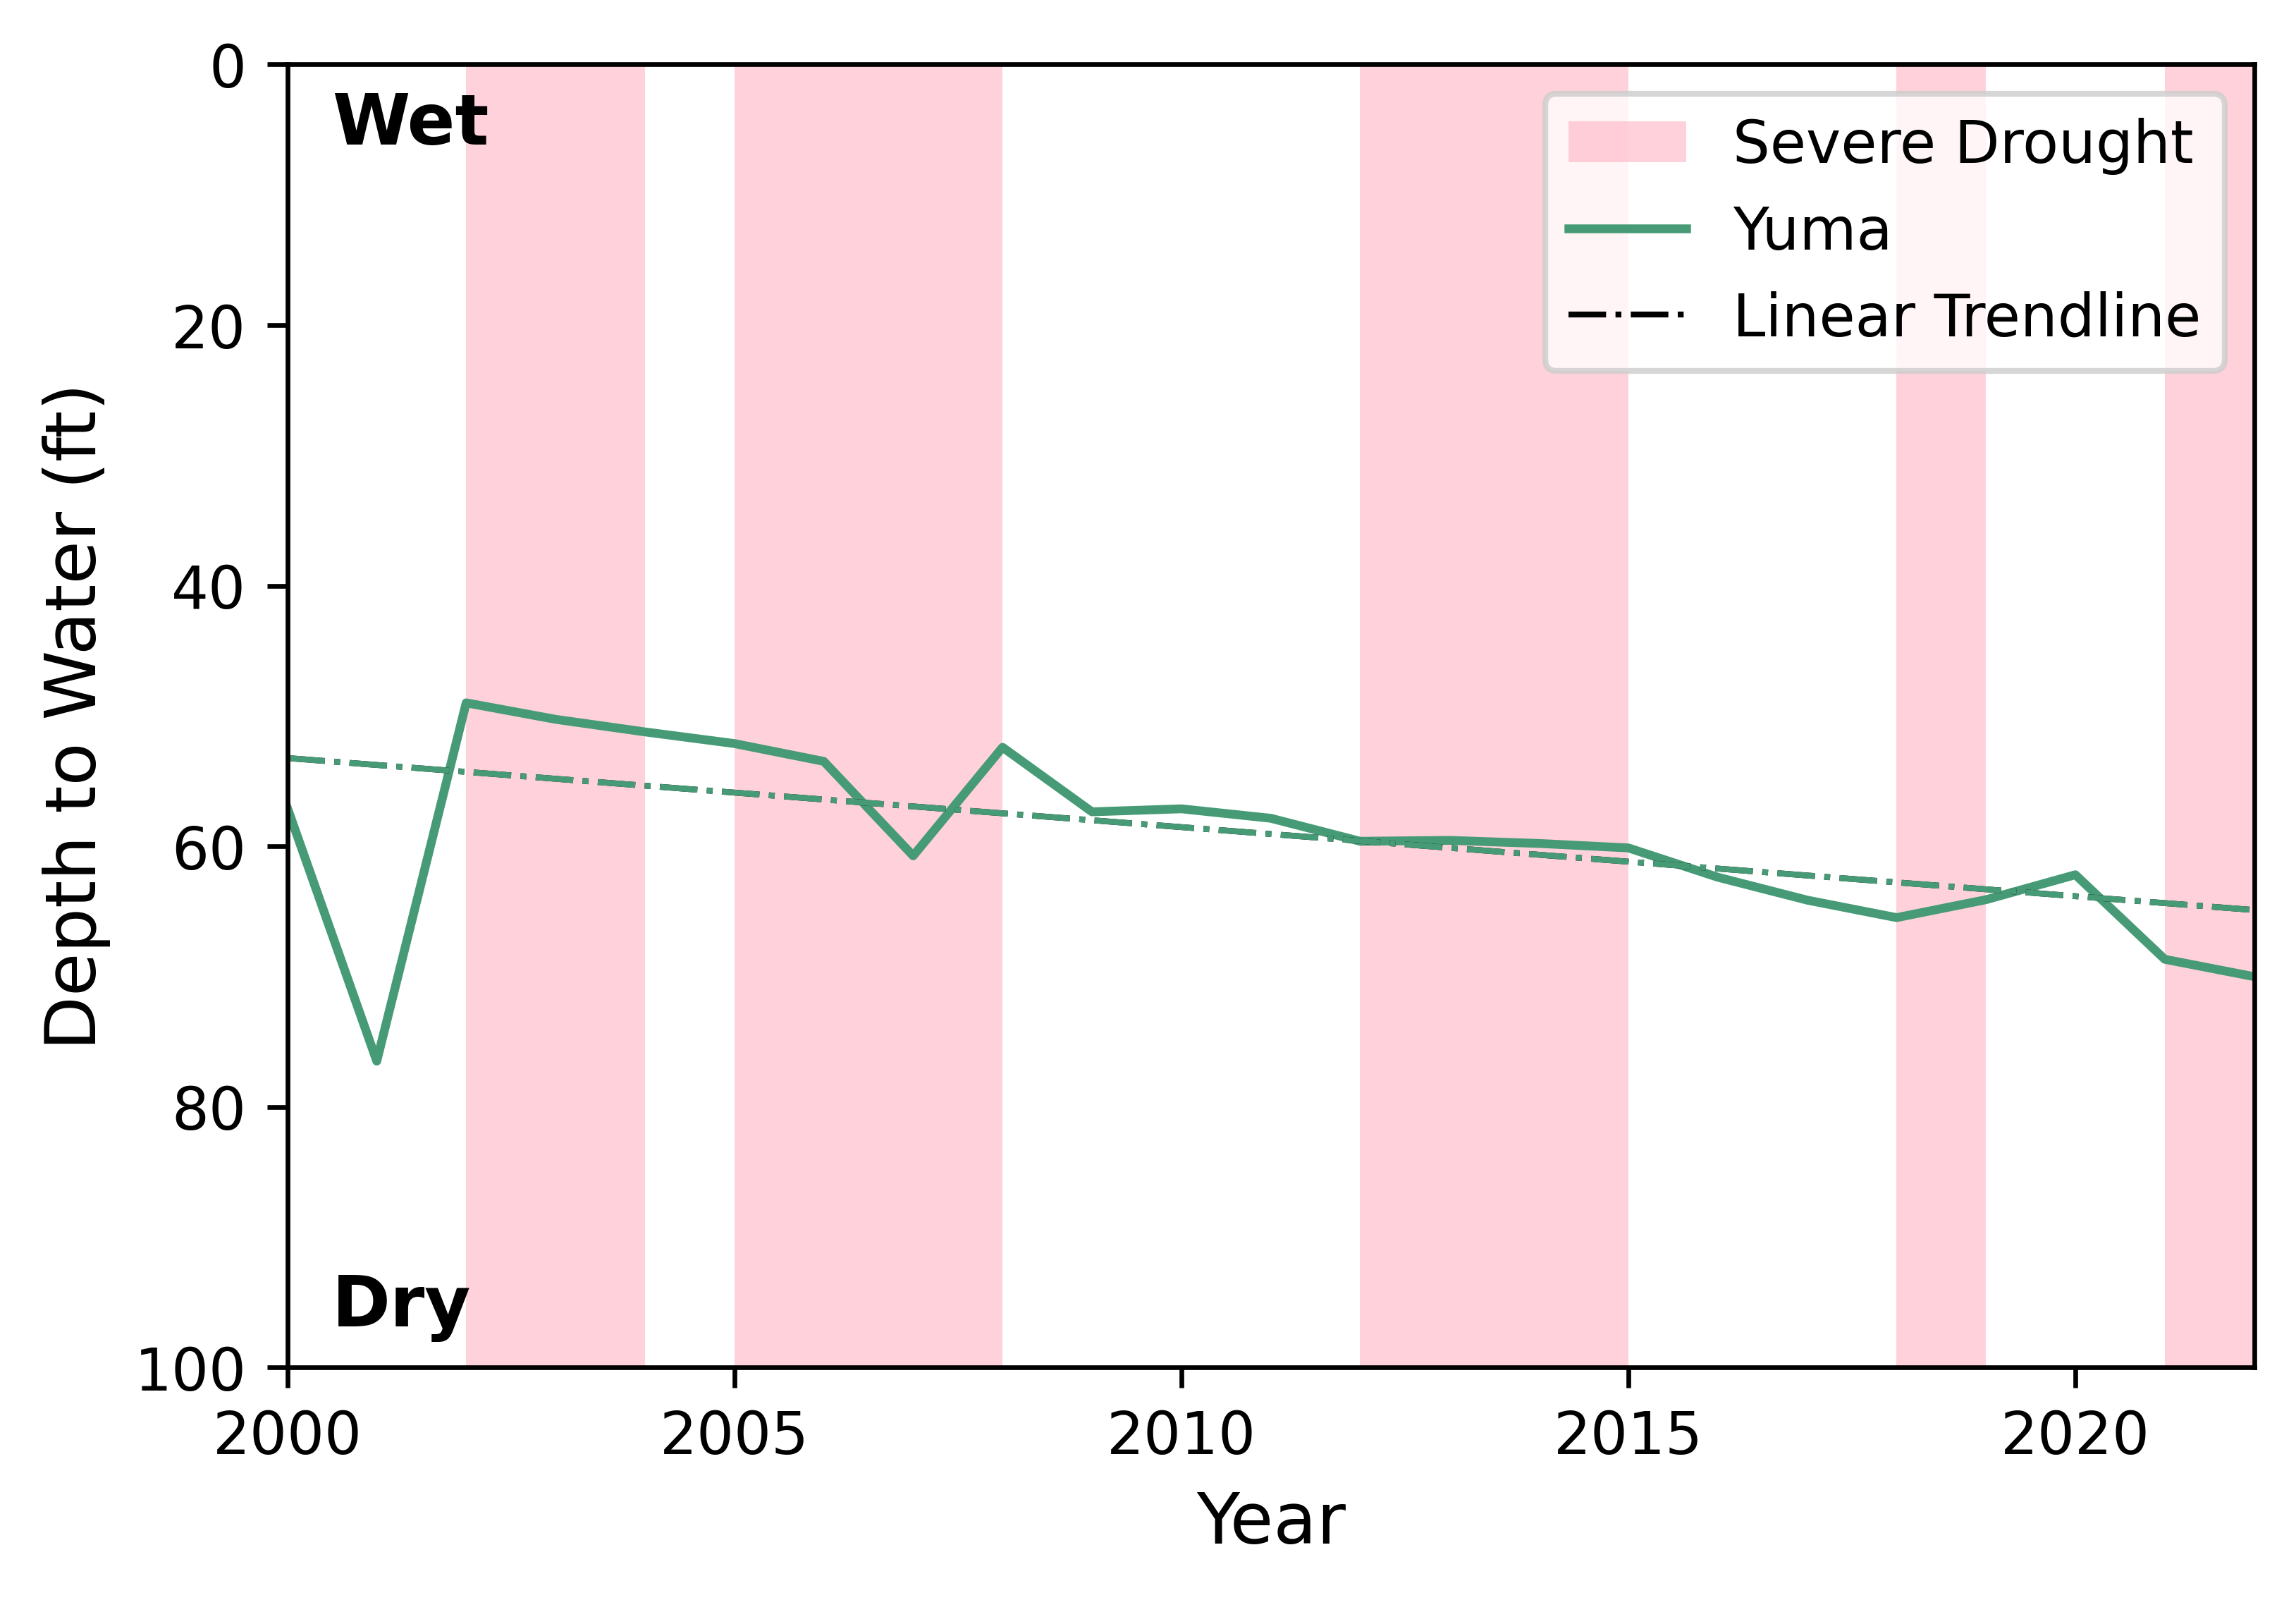

In [75]:
# For Depth to Water by regulation
# ds = wlanalysis_period
ds = df_interpolated
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea

betterlabels = [StudyArea]

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)
# stats1.to_csv(outputpath_local+'Stats_'+StudyArea+'.csv')

# -- Data visualization --
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
m1 = round(stats1.loc['slope',betterlabels[0]], 2)
yint1 = round(stats1.loc['int',betterlabels[0]], 2)
pval1 = round(stats1.loc['p_val',betterlabels[0]], 4)
yf1 = (m1*xf)+yint1

fig, ax = plt.subplots(1, 1, figsize = (6,4))

ylim = 100
fsize = 12

# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds[column_list[0]], label='Yuma', color=water_designation)

ax.plot(xf1, yf1,"-.",color='k',label='Linear Trendline', lw=1)
# ax.plot(xf1, yf1,"-.",color='k', lw=1)
ax.plot(xf1, yf1,"-.", color=water_designation, lw=1)

# Adding text inside the plot
ax.text(min_yr+0.5, 2, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, ylim-2, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(ylim,0)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=0)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

# plt.savefig(figurepath+Name, bbox_inches = 'tight')

In [76]:
# Anomaly's
# ds = wlanalysis_period.copy()
ds = df_interpolated.copy()
columns = ds.columns
column_list = ds.columns.tolist()
# trend_df = wlanalysis_period.copy()
trend_df = df_interpolated.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        # trend_df[i] = (wlanalysis_period.index*slope) + intercept
        # dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]
        trend_df[i] = (df_interpolated.index*slope) + intercept
        dtw_anomalys[i] = df_interpolated[i] - trend_df[i]
        

dtw_anomalys.head()

,YUMA
index,
2000,3.28
2001,22.18
2002,-5.85
2003,-5.11
2004,-4.68


Results for Yuma (2000-2022):
Kendall Correlation coefficient
 YUMA:
  tau = -0.004
  pval = 1.0
Spearman Correlation coefficient
 YUMA:
  rho = -0.017
  pval = 0.9394
Pearson Correlation coefficient
 YUMA:
  rsq = 0.023
  pval = 0.4861



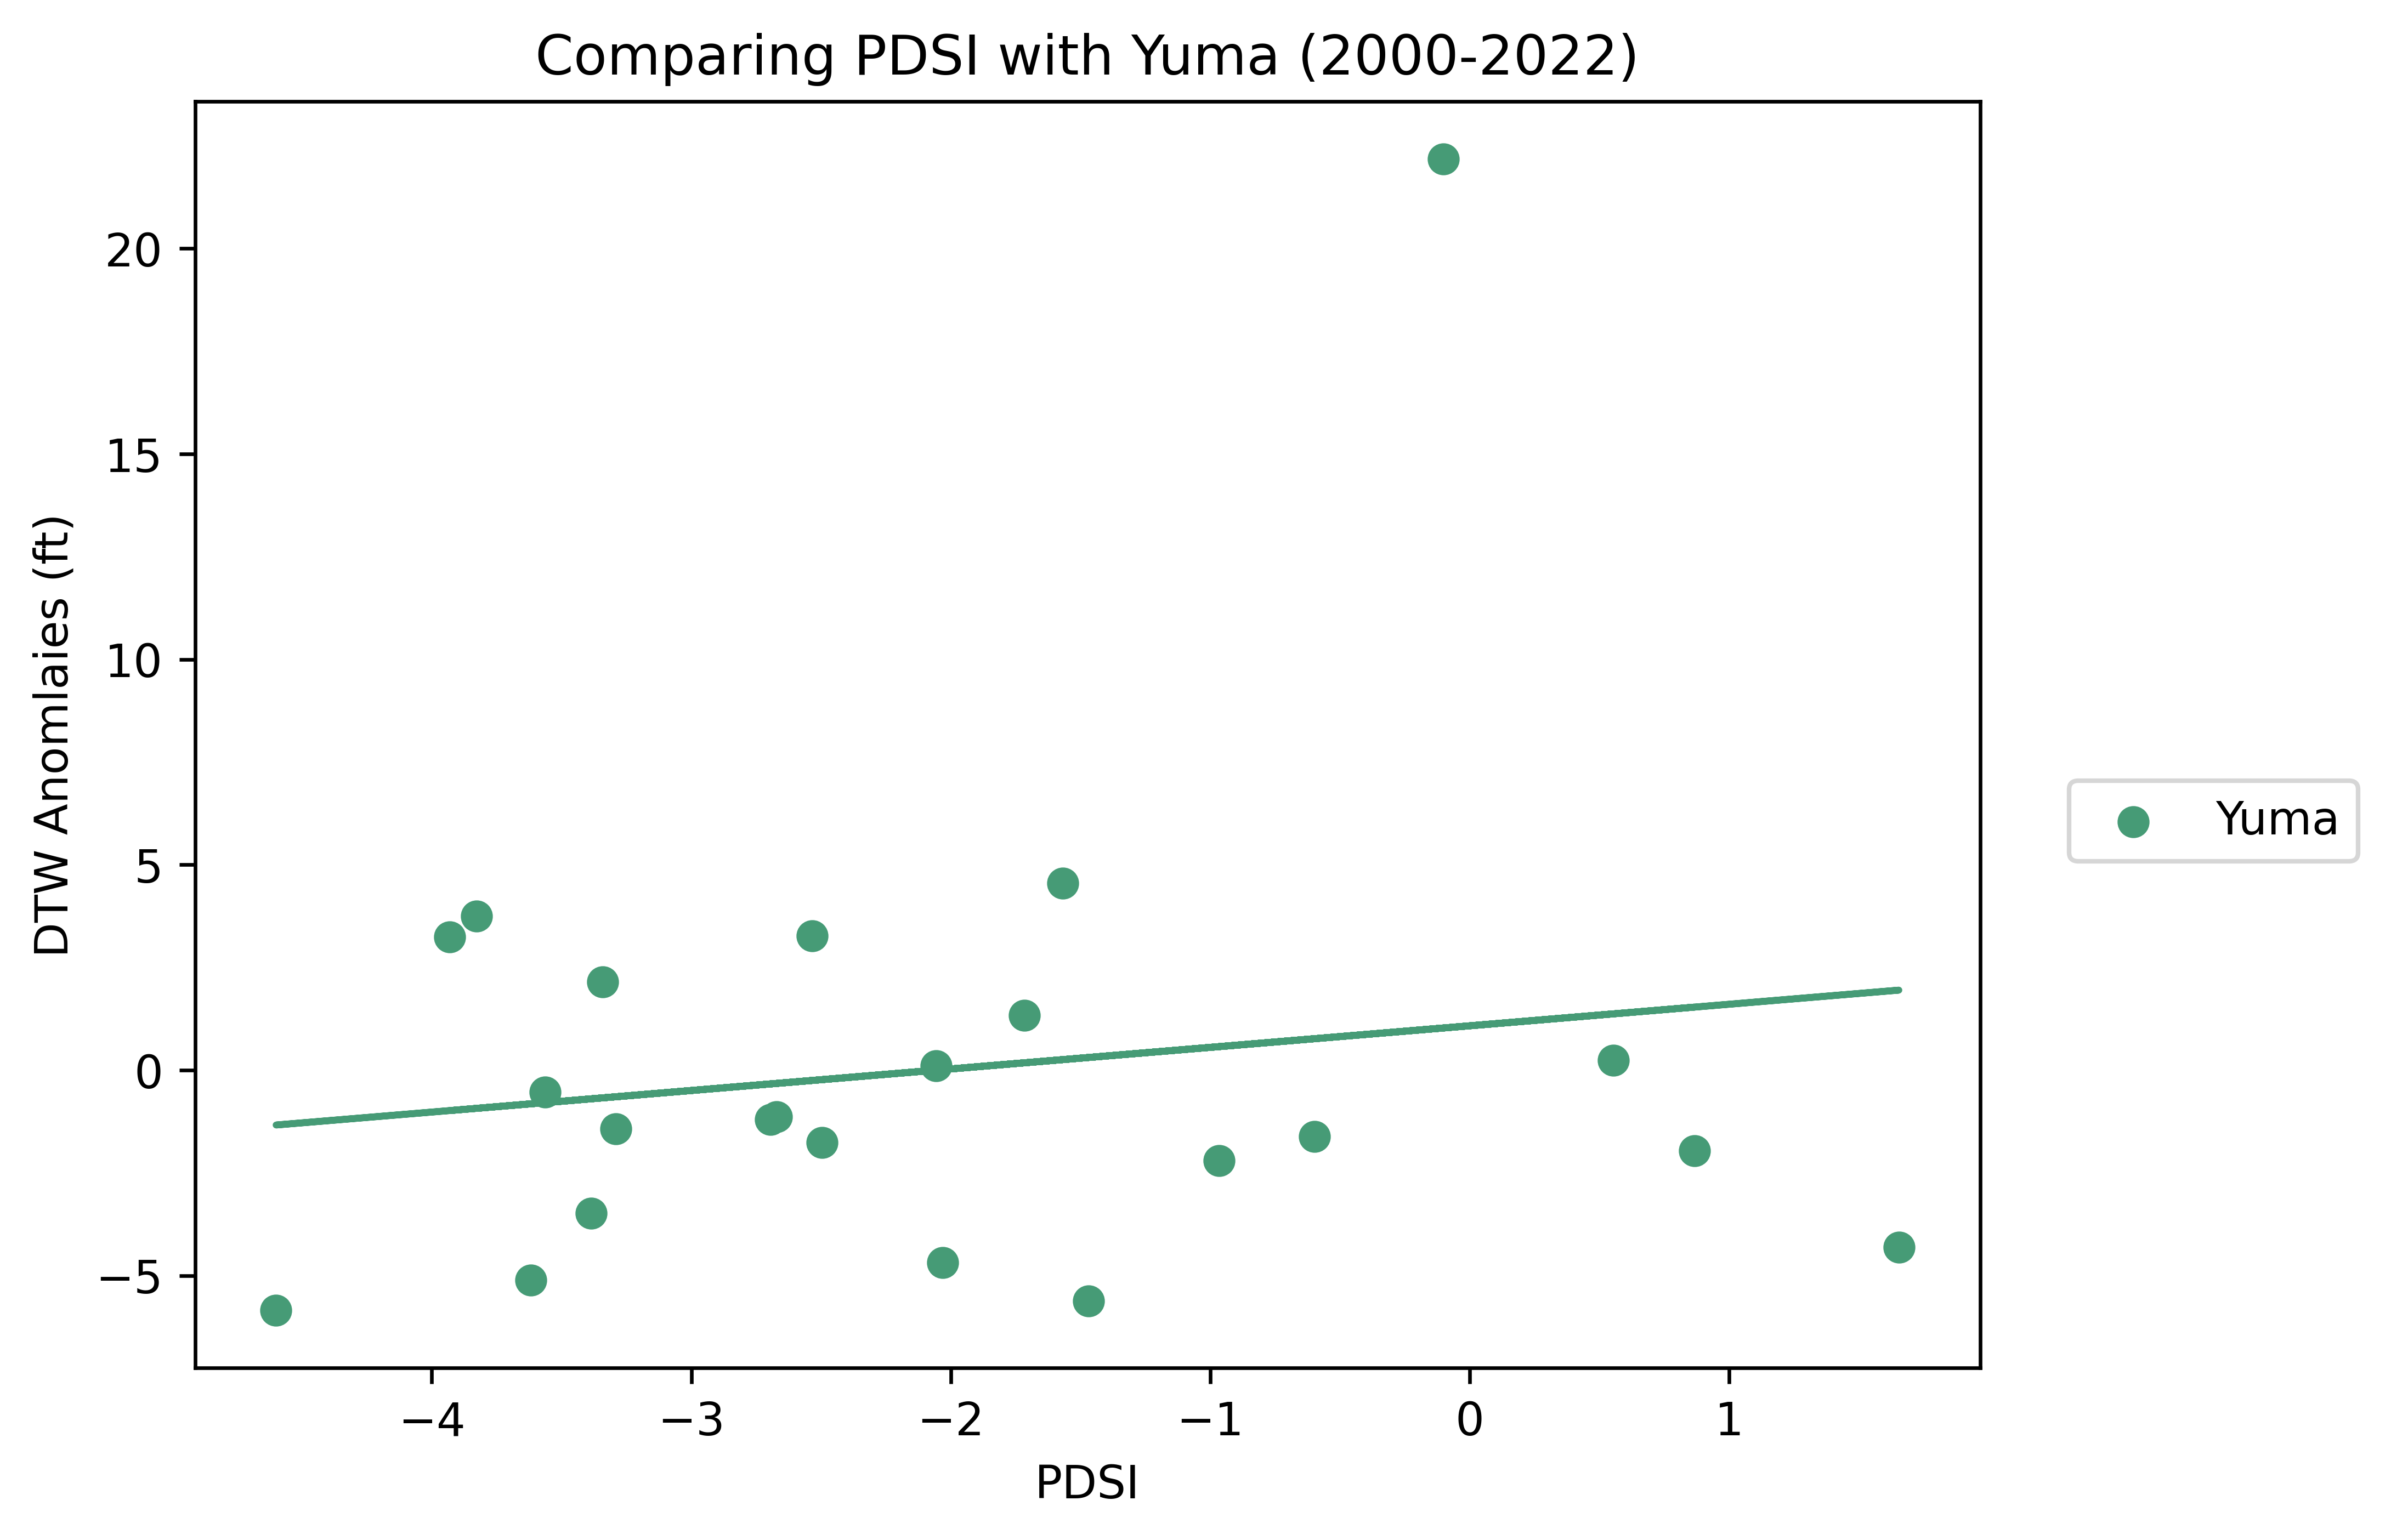

In [86]:
test_name = StudyArea+" ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices
lag = 0
indice = 'PDSI'

vert_axis = "DTW Anomlaies (ft)"

color=[swdom]

result = cf.correlation_test(ds, drought, indice, lag,test_name,color,betterlabels,vert_axis)
print(result)

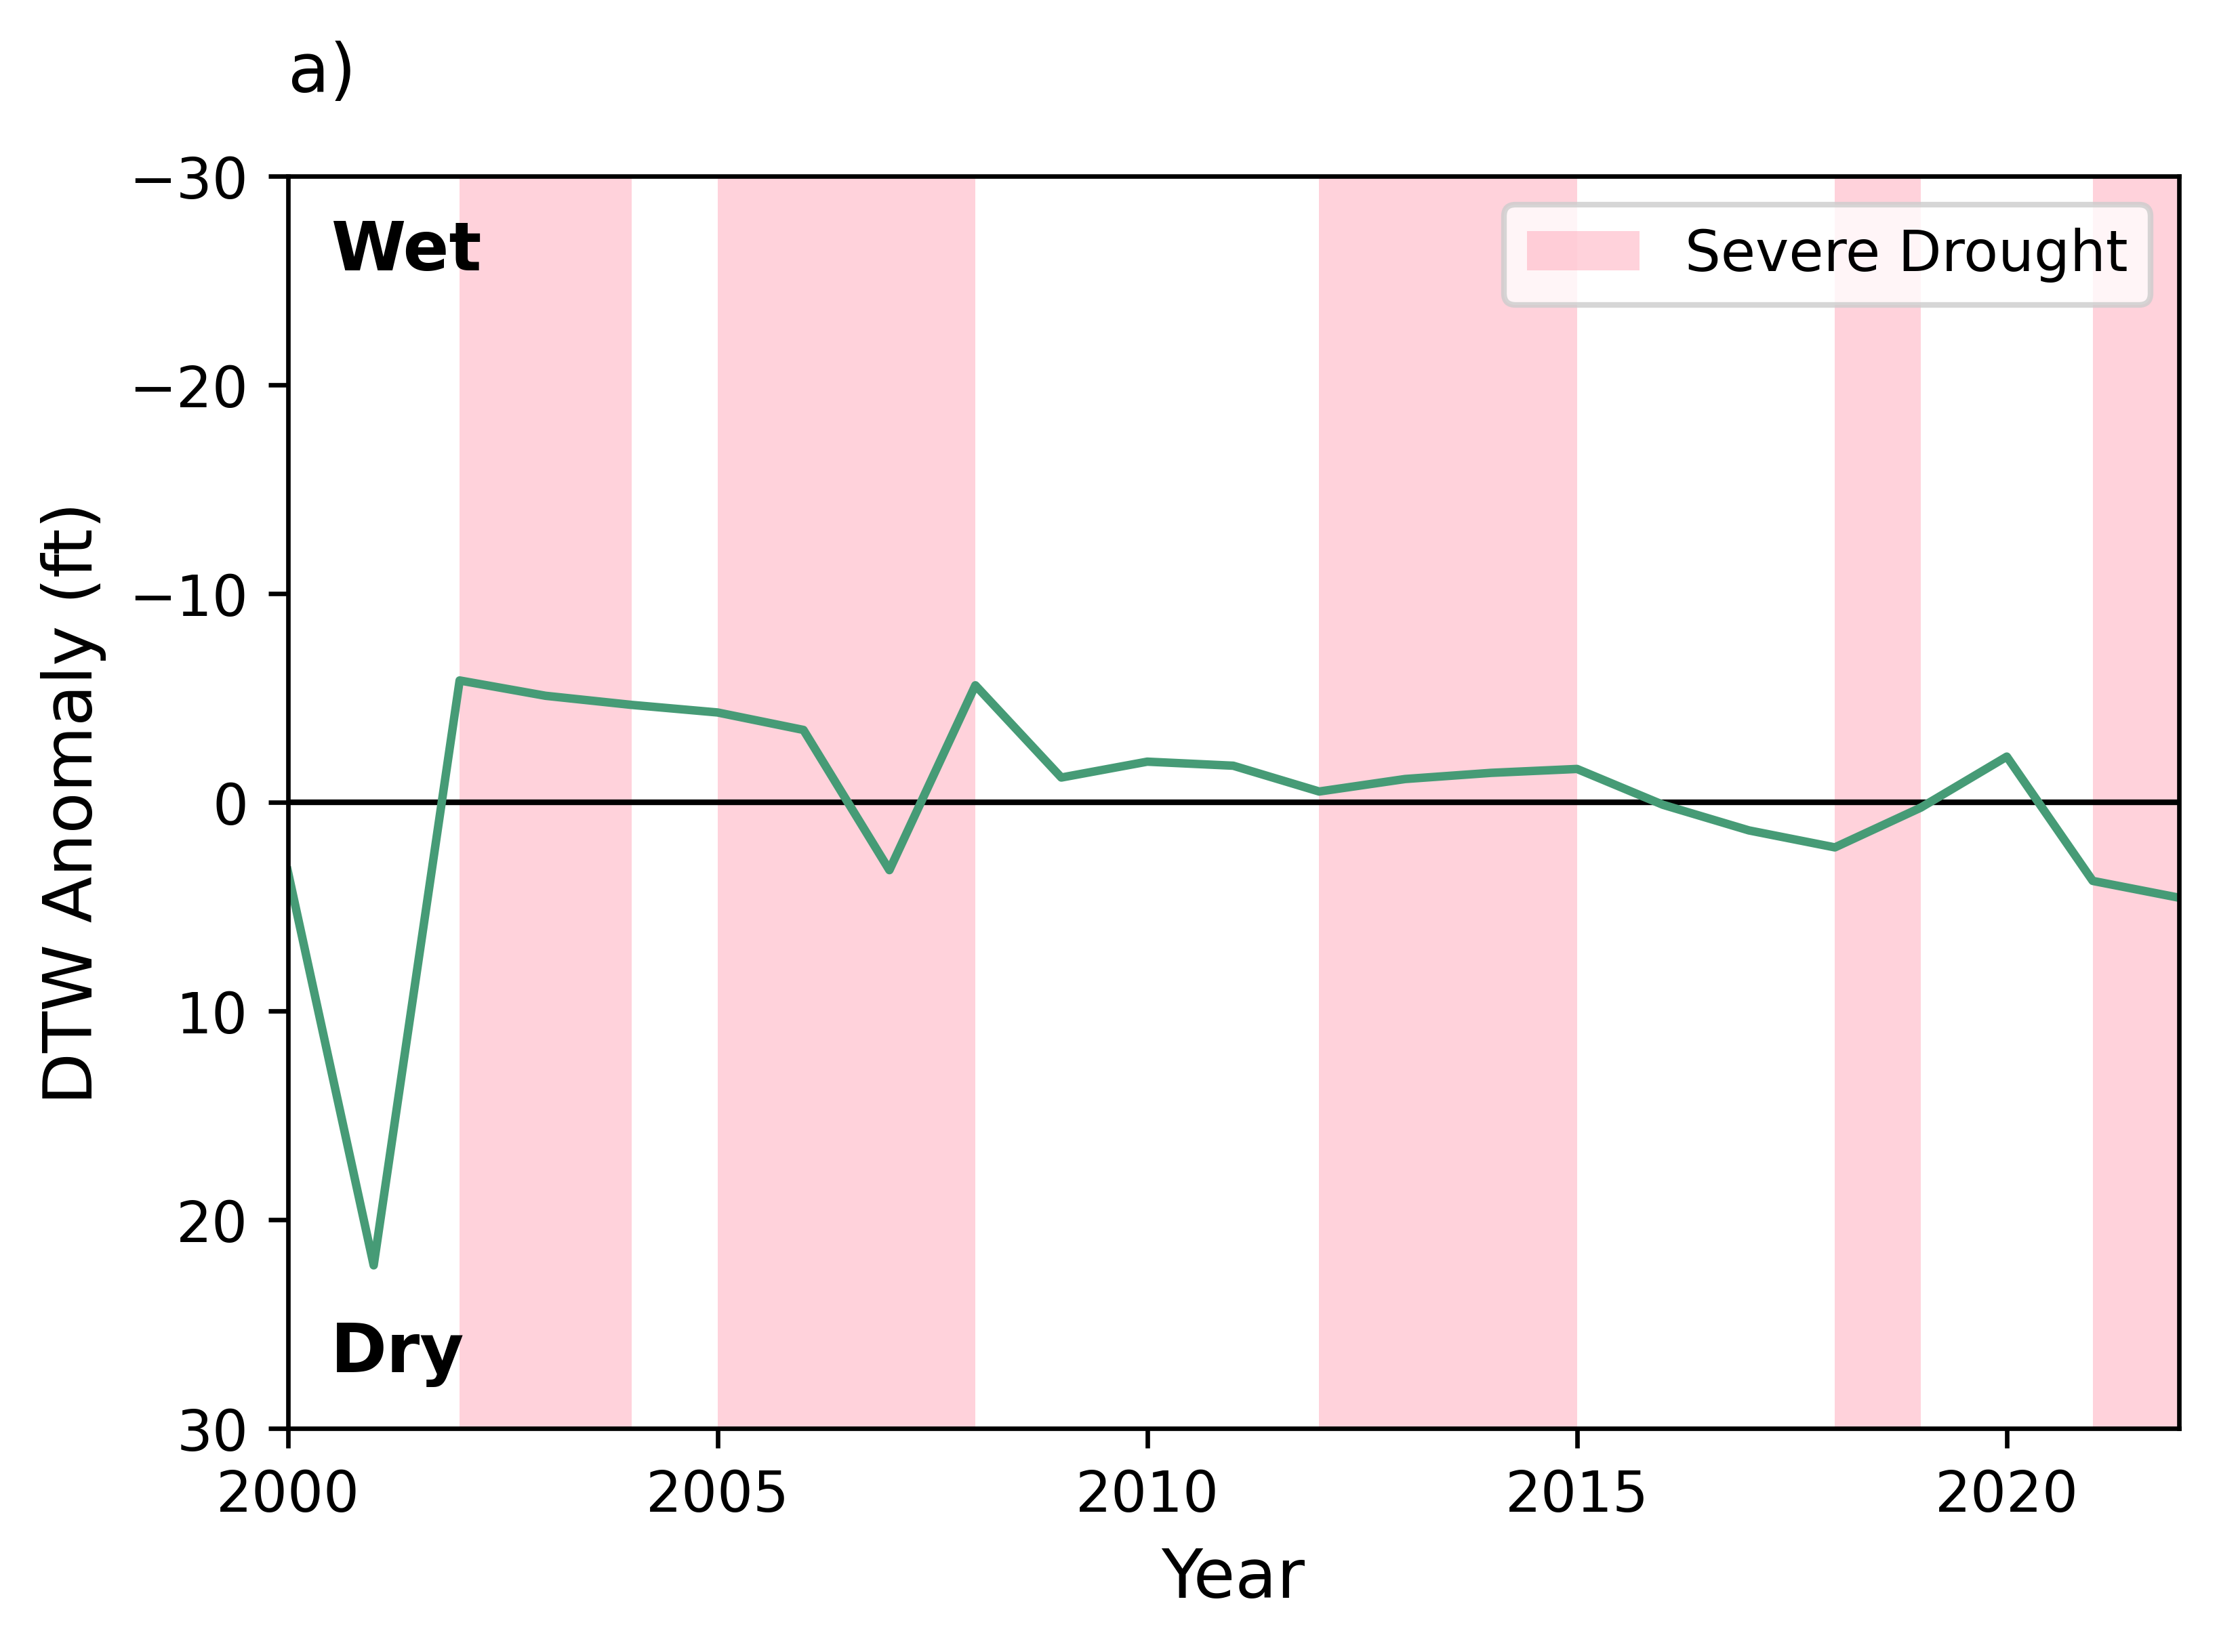

In [77]:
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

ylim = 30
fsize = 12
# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds[column_list[0]], color=water_designation, lw=1.5)
plt.axhspan(0,0,color='black',lw=1)

# Adding text inside the plot
ax.text(min_yr+0.5, 2-ylim, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, ylim-2, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(ylim,-ylim)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=0)
fig.set_dpi(600.0)
ax.set_title('a)',loc='left',pad=15, fontsize = fsize)
ax.legend(loc='upper right')

# plt.savefig(figurepath+'Timeseries of DTW Anomalies for '+StudyArea, bbox_inches = 'tight')

Calculating Max Drawdown (maximum anomaly in the drought period)

In [78]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

,YUMA
Status,
Drought 3,-5.11
Drought 4,3.24
Drought 5,-0.53
Drought 6,2.15
Drought 7,3.76
Normal-Wet,22.18


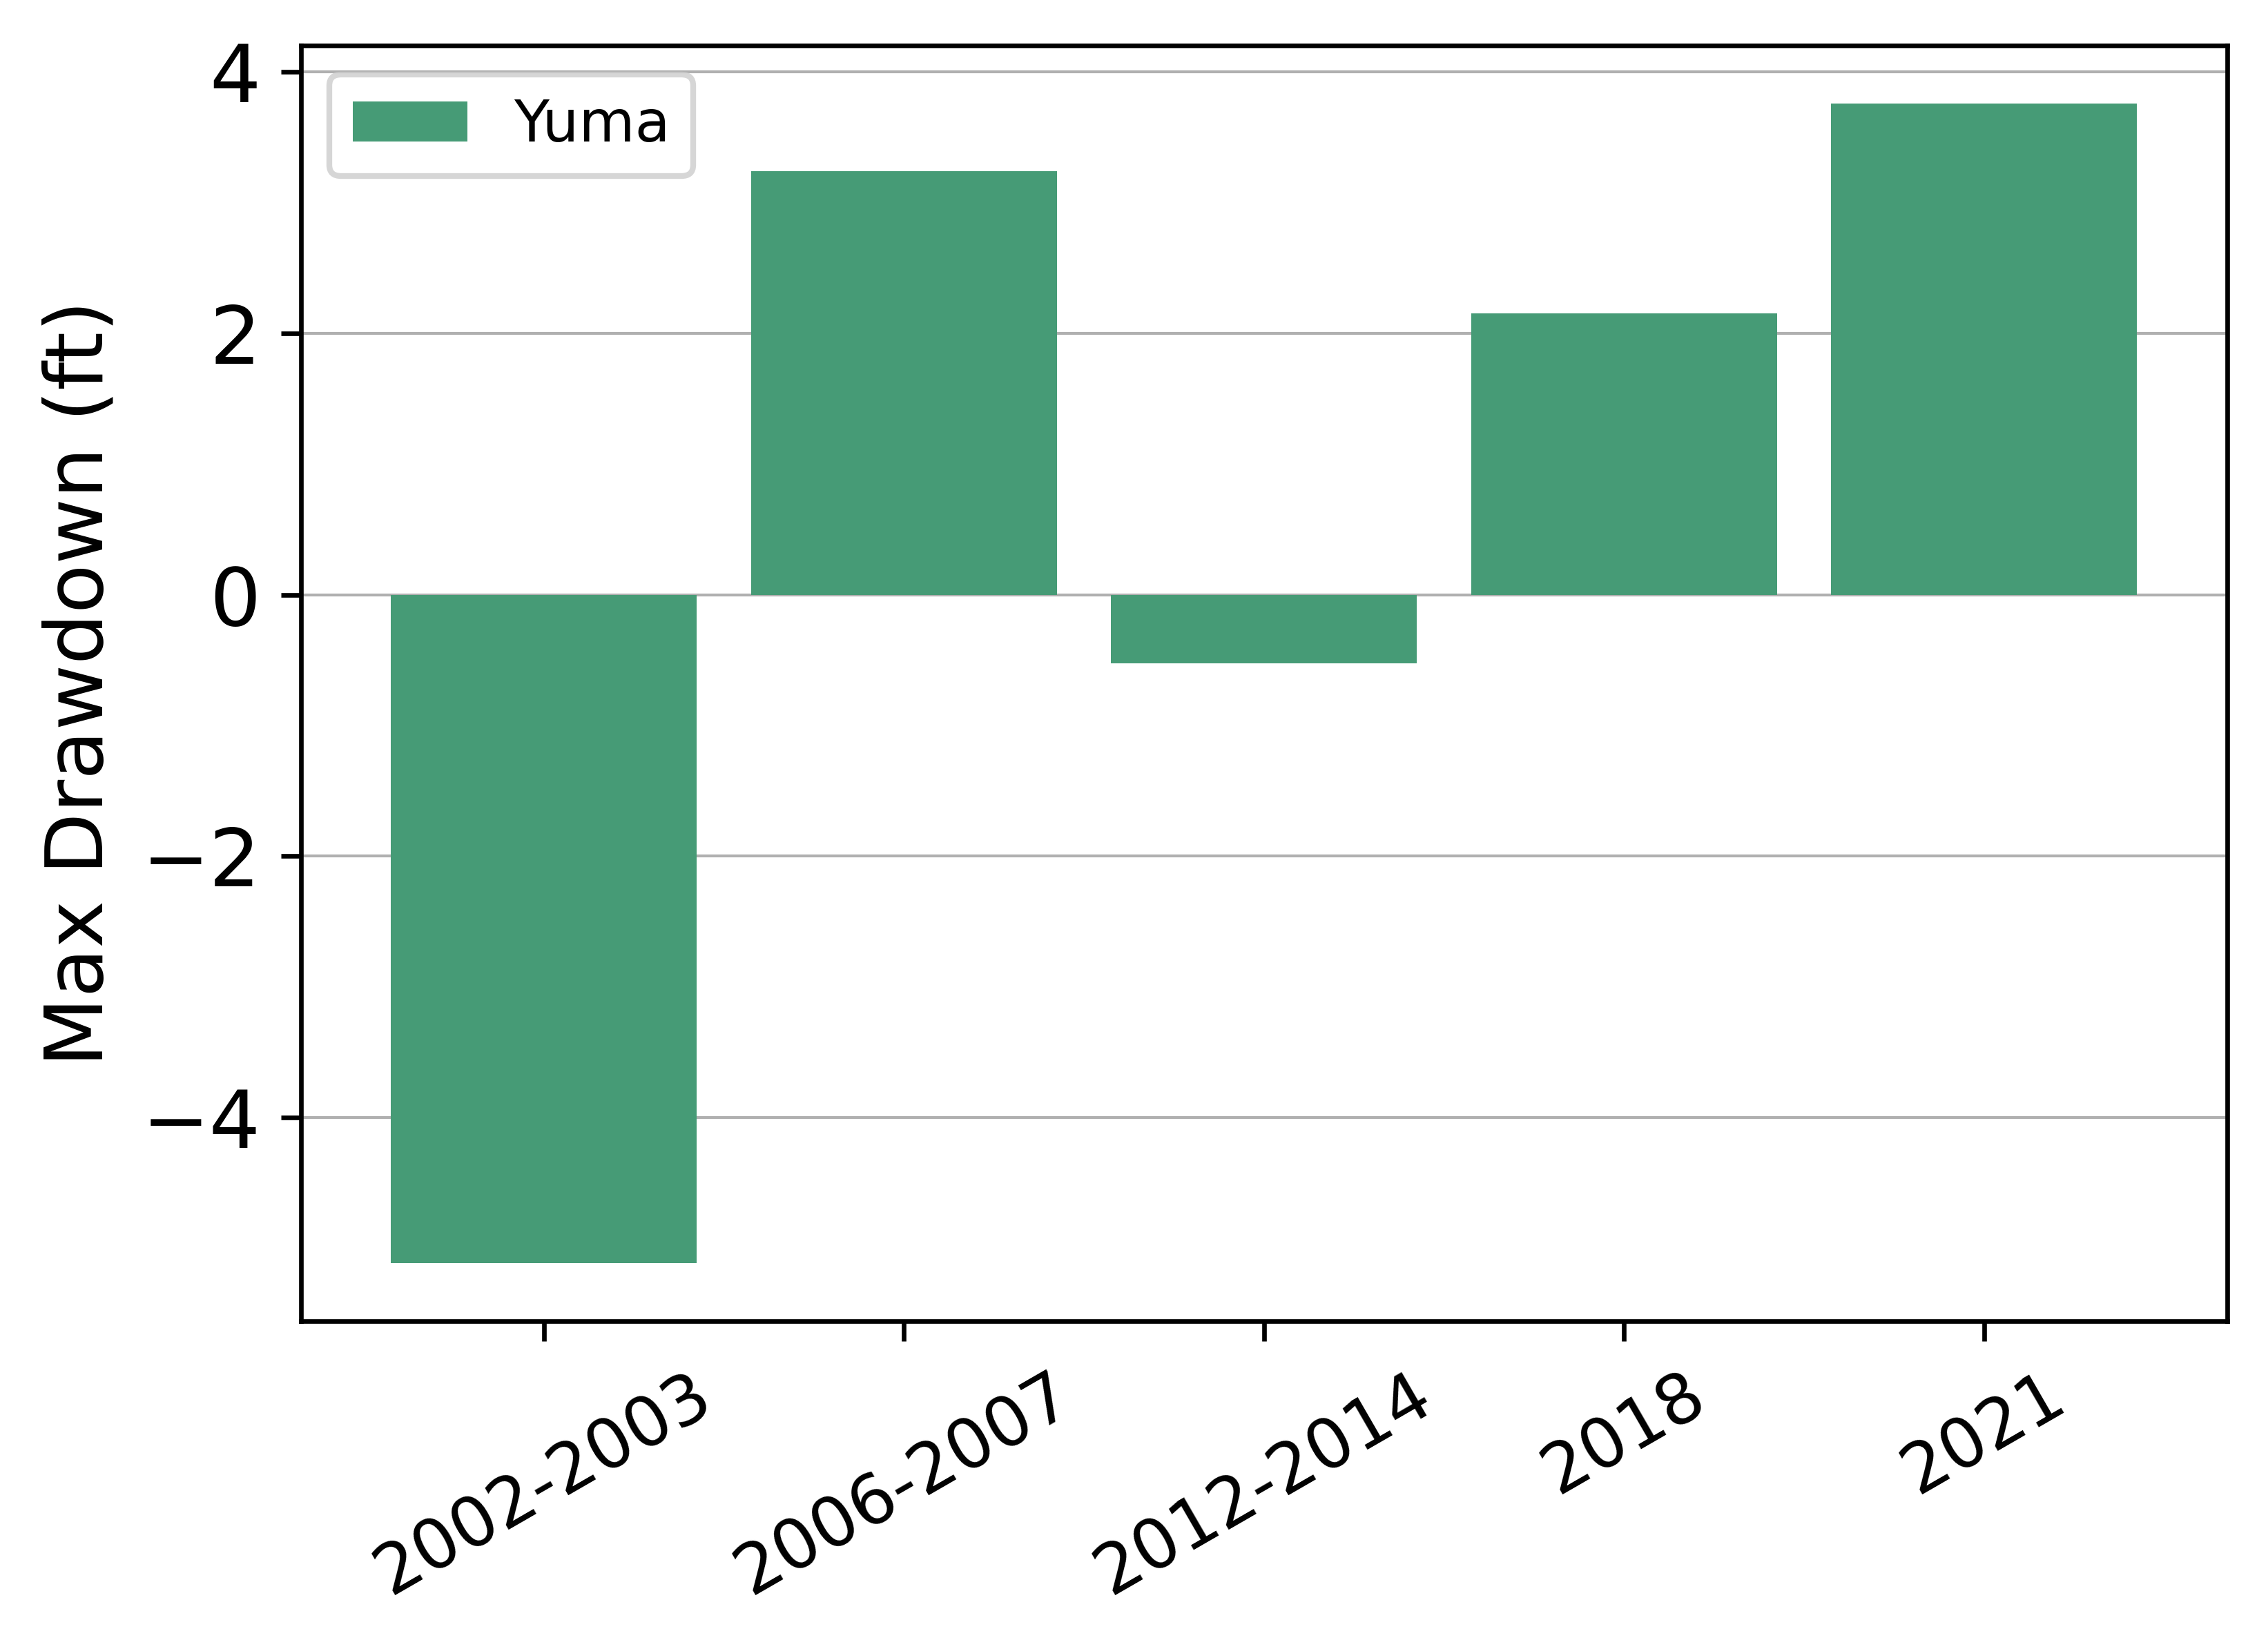

In [79]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period for '+StudyArea

yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
# betterlabels = [StudyArea]

dtw_max_anomalies.index = yearlabels
dtw_max_anomalies = dtw_max_anomalies.transpose()

dtw_max_anomalies.index = betterlabels
del dtw_max_anomalies['Normal/Wet Years']
dtw_max_anomalies = dtw_max_anomalies.transpose()

group_colors = [water_designation]

horlabel = 'Max Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (6,4),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
# plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=30, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
# plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_anomalies_groupedchart', bbox_inches = 'tight')

Run this to determine how many new wells were drilled per year in the area

In [80]:
# New wells

static_geo2['INSTALLED'] = pd.to_datetime(static_geo2['INSTALLED'])
# static_geo2['INSTALLED'].describe()

static_geo2['In_year'] = static_geo2['INSTALLED'].dt.year
new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col+"_right"], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = new_wells.reset_index()
new_wells.to_csv(outputpath+'Final_NewWells_'+StudyArea+'.csv')

In [81]:
# To get it formatted correctly

new_wells2 = pd.read_csv(outputpath+'Final_NewWells_'+StudyArea+'.csv',
                        header=2,
                        # names = ['R','Res','U']
                        names = betterlabels
                        # names = [StudyArea]
                        , index_col=0)
new_wells2

,Yuma
1930.00,1
1945.00,1
1946.00,1
1947.00,1
1951.00,2
...,...
2019.00,20
2020.00,43
2021.00,71
2022.00,40


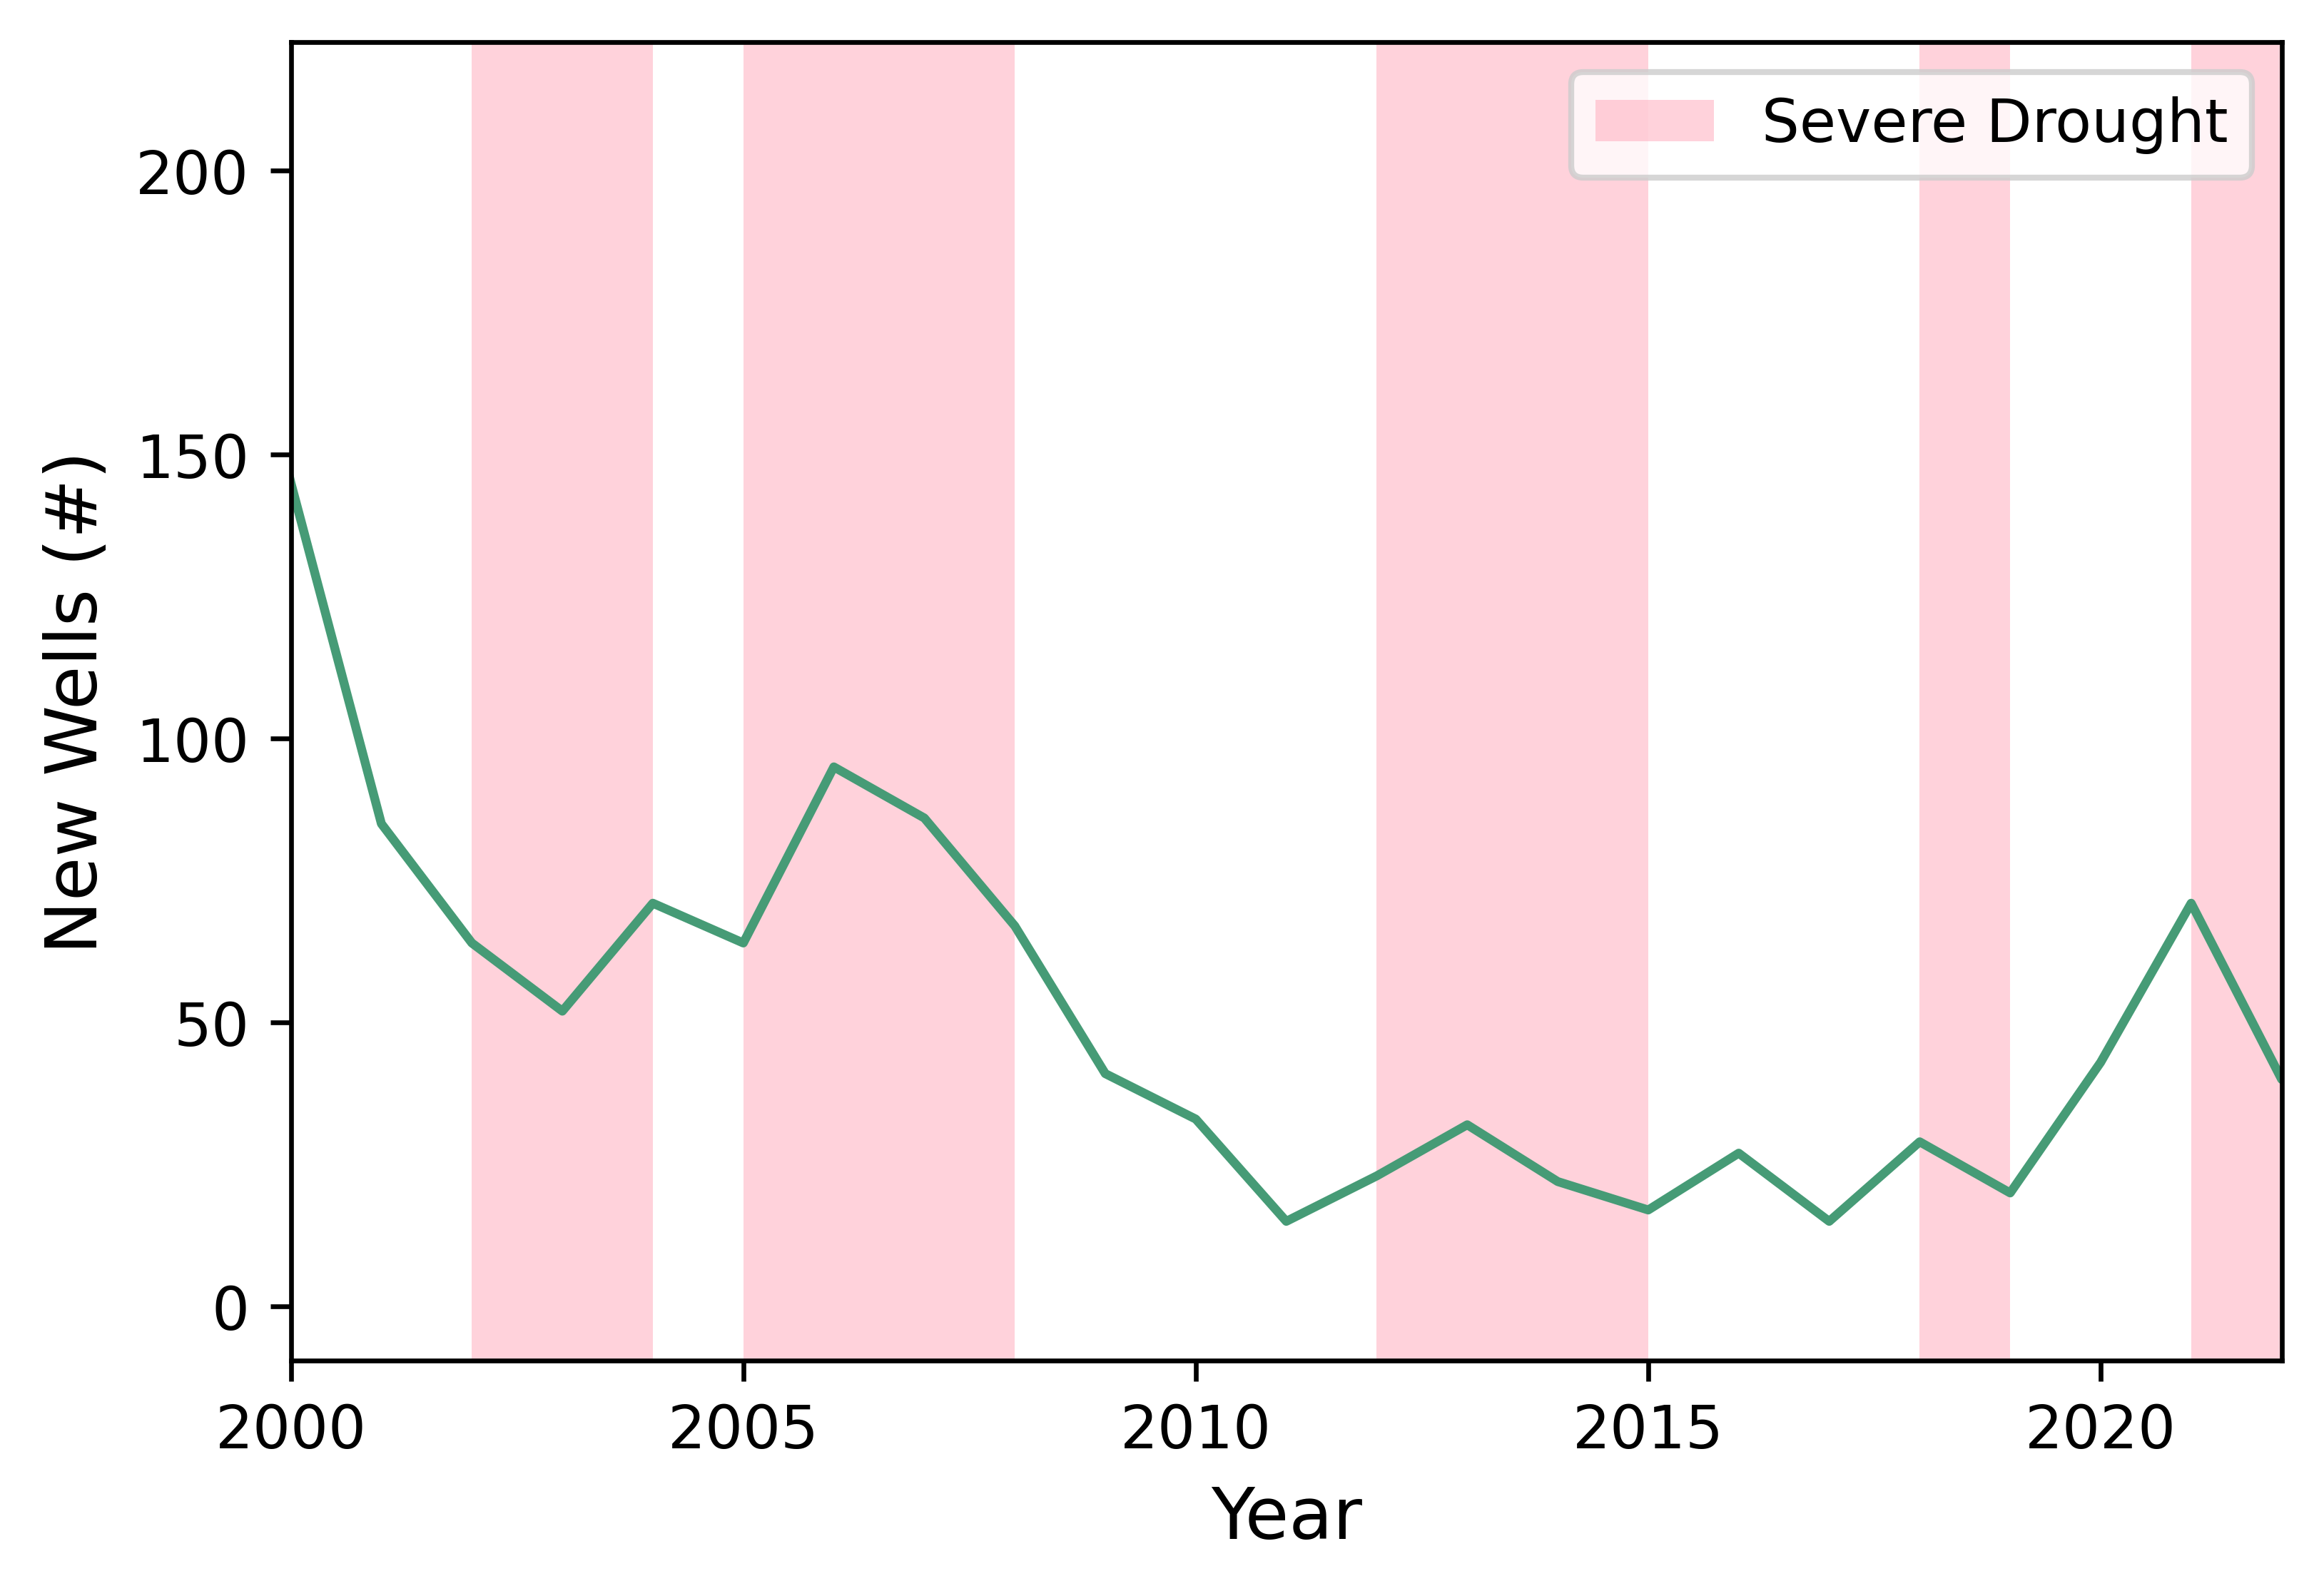

In [82]:
ds = new_wells2
min_yr = 2000
mx_yr = 2022
# betterlabels = ['Regulated','Unregulated']

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = -12
max_y = 15
fsize = 12
num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds[column_list[0]], color=water_designation, lw=1.5) 
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel('New Wells (#)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

plt.savefig(figurepath+'Timeseries of New Wells for '+StudyArea, bbox_inches = 'tight')